In [30]:
from pyexpat import features
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from aiohttp.web_routedef import static
from mpmath import residual

df = pd.read_csv("/Users/lorenzoreinoso/Documents/MIT-StreetCar-Delay/data_updated.csv")

In [31]:
df.head(10)

,Date,Week,Line,Time,Day,Location,Incident,Min Delay,Min Gap,Bound,Vehicle
0,2024-01-01,1,505,02:45,Monday,DUNDAS AND MCCAUL,Security,10,20,W,4416
1,2024-01-01,1,505,03:06,Monday,COLLEGE AND GLADSTONE,Emergency Services,52,72,E,4461
2,2024-01-01,1,503,03:21,Monday,PARLIAMENT AND SHUTTER,Security,0,0,N,4545
3,2024-01-01,1,505,03:53,Monday,DUNDAS WEST STATION,Security,37,0,W,4551
4,2024-01-01,1,600,04:27,Monday,QUEEN AND BATHURST,Diversion,78,93,E,8116
5,2024-01-01,1,501,04:33,Monday,QUEEN AND BATHRUST,Diversion,74,84,E,3531
6,2024-01-01,1,501,04:39,Monday,QUEEN AND PORTLAND,Diversion,39,49,W,4516
7,2024-01-01,1,507,04:52,Monday,RONCESVALLES YARD,General Delay,6,18,E,4479
8,2024-01-01,1,506,04:53,Monday,RONCESVALLE YARD,General Delay,13,28,E,4408
9,2024-01-01,1,501,04:54,Monday,RONCESVALLES YARD,General Delay,15,30,W,4411


In [32]:
df.shape

(11087, 11)

In [33]:
df = df[df["Min Delay"]!=0]
df.shape

(9228, 11)

In [34]:
df.head()

,Date,Week,Line,Time,Day,Location,Incident,Min Delay,Min Gap,Bound,Vehicle
0,2024-01-01,1,505,02:45,Monday,DUNDAS AND MCCAUL,Security,10,20,W,4416
1,2024-01-01,1,505,03:06,Monday,COLLEGE AND GLADSTONE,Emergency Services,52,72,E,4461
3,2024-01-01,1,505,03:53,Monday,DUNDAS WEST STATION,Security,37,0,W,4551
4,2024-01-01,1,600,04:27,Monday,QUEEN AND BATHURST,Diversion,78,93,E,8116
5,2024-01-01,1,501,04:33,Monday,QUEEN AND BATHRUST,Diversion,74,84,E,3531


We want to make sure that we are taking into consideration all the events that had delay in order to predict, the time that it will take for them to arrive.

It's really important to take into consideration as much valuable information as we can.

In [35]:
# Function created for aesthetic, if we have more than 3 values it adds a ...
def format_unique_values(values):
    if len(values) > 3:
        return f"{list(values[:3])} ... ({len(values)} unique values)"
    return list(values)

# This is added for structure
summary = {
    'Data Type': df.dtypes, # Luego el tipo de dato
    'Unique Values': [df[col].nunique() for col in df.columns], # luego el número de valores unicos
    'Sample Values': [format_unique_values(df[col].unique()) for col in df.columns], # Usando la función de arriba mostrar algunos valores
    'Missing Values': df.isnull().sum(), # Cantidad de valores Faltantes
    'Missing %': round(df.isnull().sum() / len(df) * 100,2) # Es la proporción cuantos valores hay faltantes
}

details = pd.DataFrame(summary)

# This part is added to format the final table
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.width', 1000)
styled_details = details.style.set_properties(**{
    'text-align': 'left',
    'white-space': 'pre-wrap'
}).set_table_styles([
    {'selector': 'th', 'props': [('background-color', '#f0f0f0'),
                                ('color', 'black'),
                                ('font-weight', 'bold'),
                                ('text-align', 'left'),
                                ('padding', '8px')]},
    {'selector': 'td', 'props': [('padding', '8px')]}
])

display(styled_details)

# Final Resume
print("\nShape of the DF (rows, columns):", df.shape)
print(f"Rows: {df.shape[0]}")
print(f"Columns: {df.shape[1]}")

,Data Type,Unique Values,Sample Values,Missing Values,Missing %
Date,object,274,"['2024-01-01', '2024-01-02', '2024-01-03'] ... (274 unique values)",0,0.000000
Week,int64,40,"[1, 2, 3] ... (40 unique values)",0,0.000000
Line,object,30,"['505', '600', '501'] ... (31 unique values)",16,0.170000
Time,object,1425,"['02:45', '03:06', '03:53'] ... (1425 unique values)",0,0.000000
Day,object,7,"['Monday', 'Tuesday', 'Wednesday'] ... (7 unique values)",0,0.000000
Location,object,1632,"['DUNDAS AND MCCAUL', 'COLLEGE AND GLADSTONE', 'DUNDAS WEST STATION'] ... (1633 unique values)",1,0.010000
Incident,object,13,"['Security', 'Emergency Services', 'Diversion'] ... (13 unique values)",0,0.000000
Min Delay,int64,196,"[10, 52, 37] ... (196 unique values)",0,0.000000
Min Gap,int64,205,"[20, 72, 0] ... (205 unique values)",0,0.000000
Bound,object,6,"['W', 'E', nan] ... (7 unique values)",1071,11.610000



Shape of the DF (rows, columns): (9228, 11)
Rows: 9228
Columns: 11


With this analysis we can notice that we have some NAN values, in two columns Line and bound, they add up to 11% of our data set

Also with this table we can notice that there might be an "id" value, as the column with more Unique values is Vehicle, and can be Interpreted as something as a "car plate".

In [36]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9228 entries, 0 to 11085
Data columns (total 11 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Date       9228 non-null   object
 1   Week       9228 non-null   int64 
 2   Line       9212 non-null   object
 3   Time       9228 non-null   object
 4   Day        9228 non-null   object
 5   Location   9227 non-null   object
 6   Incident   9228 non-null   object
 7   Min Delay  9228 non-null   int64 
 8   Min Gap    9228 non-null   int64 
 9   Bound      8157 non-null   object
 10  Vehicle    9228 non-null   int64 
dtypes: int64(4), object(7)
memory usage: 865.1+ KB


With this approach we can see the data type of each of our columns most of them are categorical

In [37]:
# Lets work on our missing values

# Line has 16 registers with empty values, as it represents less than 1% of our data set it won't harm dropping them
df = df.dropna(subset=['Line'])
# Location has one empty value, lets drop it
df = df.dropna(subset=['Location'])

In [38]:
df["Bound"].value_counts()

Bound
W    2999
E    2977
N    1089
S    1077
B       2
8       1
Name: count, dtype: int64

In [39]:
# looking into the possible of our data in Bound, we can see the Cardinal point, and some "weird" values, also we have 1071 empty values representing 11.61% of our data set, if we get rid of them we are losing a los of info, that's why we are creating the category "other"
df['Bound'] = df['Bound'].replace(['B', '8', np.nan], 'Other')
df["Bound"].value_counts()

Bound
W        2999
E        2977
N        1089
S        1077
Other    1069
Name: count, dtype: int64

Some the key aspects are now we dont have missing values, and we kept, as much information as possible.

In [40]:
# Function created for aesthetic, if we have more than 3 values it adds a ...
def format_unique_values(values):
    if len(values) > 3:
        return f"{list(values[:3])} ... ({len(values)} unique values)"
    return list(values)

# This is added for structure
summary = {
    'Data Type': df.dtypes, # Luego el tipo de dato
    'Unique Values': [df[col].nunique() for col in df.columns], # luego el número de valores unicos
    'Sample Values': [format_unique_values(df[col].unique()) for col in df.columns], # Usando la función de arriba mostrar algunos valores
    'Missing Values': df.isnull().sum(), # Cantidad de valores Faltantes
    'Missing %': round(df.isnull().sum() / len(df) * 100,2) # Es la proporción cuantos valores hay faltantes
}

details = pd.DataFrame(summary)

# This part is added to format the final table
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.width', 1000)
styled_details = details.style.set_properties(**{
    'text-align': 'left',
    'white-space': 'pre-wrap'
}).set_table_styles([
    {'selector': 'th', 'props': [('background-color', '#f0f0f0'),
                                ('color', 'black'),
                                ('font-weight', 'bold'),
                                ('text-align', 'left'),
                                ('padding', '8px')]},
    {'selector': 'td', 'props': [('padding', '8px')]}
])

display(styled_details)

# Final Resume
print("\nShape of the DF (rows, columns):", df.shape)
print(f"Rows: {df.shape[0]}")
print(f"Columns: {df.shape[1]}")


,Data Type,Unique Values,Sample Values,Missing Values,Missing %
Date,object,274,"['2024-01-01', '2024-01-02', '2024-01-03'] ... (274 unique values)",0,0.000000
Week,int64,40,"[1, 2, 3] ... (40 unique values)",0,0.000000
Line,object,30,"['505', '600', '501'] ... (30 unique values)",0,0.000000
Time,object,1425,"['02:45', '03:06', '03:53'] ... (1425 unique values)",0,0.000000
Day,object,7,"['Monday', 'Tuesday', 'Wednesday'] ... (7 unique values)",0,0.000000
Location,object,1630,"['DUNDAS AND MCCAUL', 'COLLEGE AND GLADSTONE', 'DUNDAS WEST STATION'] ... (1630 unique values)",0,0.000000
Incident,object,13,"['Security', 'Emergency Services', 'Diversion'] ... (13 unique values)",0,0.000000
Min Delay,int64,196,"[10, 52, 37] ... (196 unique values)",0,0.000000
Min Gap,int64,205,"[20, 72, 0] ... (205 unique values)",0,0.000000
Bound,object,5,"['W', 'E', 'Other'] ... (5 unique values)",0,0.000000



Shape of the DF (rows, columns): (9211, 11)
Rows: 9211
Columns: 11


We removed 17 values from the original data set, and joined some categorical features for the moment.

In [41]:
# Let's clean and prepare the information

# time is a categorical feature, but it can be represented on a scale from 0-1440 (0-24 hours in minutes)
df['Time'] = pd.to_datetime(df['Time'], format='%H:%M').dt.hour * 60 + pd.to_datetime(df['Time'], format='%H:%M').dt.minute

In [42]:
# Let's make the date "more understandable"
df['Date'] = pd.to_datetime(df['Date'])
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['Day'] = df['Date'].dt.day
df.drop("Date", axis=1, inplace=True) # as we extracted what we needed we can get rid of this column

In [43]:
# Function created for aesthetic, if we have more than 3 values it adds a ...
def format_unique_values(values):
    if len(values) > 3:
        return f"{list(values[:3])} ... ({len(values)} unique values)"
    return list(values)

# This is added for structure
summary = {
    'Data Type': df.dtypes, # Luego el tipo de dato
    'Unique Values': [df[col].nunique() for col in df.columns], # luego el número de valores unicos
    'Sample Values': [format_unique_values(df[col].unique()) for col in df.columns], # Usando la función de arriba mostrar algunos valores
    'Missing Values': df.isnull().sum(), # Cantidad de valores Faltantes
    'Missing %': round(df.isnull().sum() / len(df) * 100,2) # Es la proporción cuantos valores hay faltantes
}

details = pd.DataFrame(summary)

# This part is added to format the final table
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.width', 1000)
styled_details = details.style.set_properties(**{
    'text-align': 'left',
    'white-space': 'pre-wrap'
}).set_table_styles([
    {'selector': 'th', 'props': [('background-color', '#f0f0f0'),
                                ('color', 'black'),
                                ('font-weight', 'bold'),
                                ('text-align', 'left'),
                                ('padding', '8px')]},
    {'selector': 'td', 'props': [('padding', '8px')]}
])

display(styled_details)

# Final Resume
print("\nShape of the DF (rows, columns):", df.shape)
print(f"Rows: {df.shape[0]}")
print(f"Columns: {df.shape[1]}")

,Data Type,Unique Values,Sample Values,Missing Values,Missing %
Week,int64,40,"[1, 2, 3] ... (40 unique values)",0,0.000000
Line,object,30,"['505', '600', '501'] ... (30 unique values)",0,0.000000
Time,int32,1425,"[165, 186, 233] ... (1425 unique values)",0,0.000000
Day,int32,31,"[1, 2, 3] ... (31 unique values)",0,0.000000
Location,object,1630,"['DUNDAS AND MCCAUL', 'COLLEGE AND GLADSTONE', 'DUNDAS WEST STATION'] ... (1630 unique values)",0,0.000000
Incident,object,13,"['Security', 'Emergency Services', 'Diversion'] ... (13 unique values)",0,0.000000
Min Delay,int64,196,"[10, 52, 37] ... (196 unique values)",0,0.000000
Min Gap,int64,205,"[20, 72, 0] ... (205 unique values)",0,0.000000
Bound,object,5,"['W', 'E', 'Other'] ... (5 unique values)",0,0.000000
Vehicle,int64,1012,"[4416, 4461, 4551] ... (1012 unique values)",0,0.000000



Shape of the DF (rows, columns): (9211, 12)
Rows: 9211
Columns: 12


In [44]:
# As year is a "constant" we can drop it
df.drop("Year", axis=1, inplace=True)

In [45]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Week,9211.0,19.600586,11.490938,1.0,9.0,19.0,30.0,40.0
Time,9211.0,796.409510,382.466572,0.0,504.0,837.0,1103.0,1439.0
Day,9211.0,15.631202,8.875922,1.0,8.0,16.0,23.0,31.0
Min Delay,9211.0,18.560417,34.648966,1.0,9.0,10.0,15.0,873.0
Min Gap,9211.0,27.909673,35.590619,0.0,18.0,20.0,25.0,883.0
Vehicle,9211.0,5159.474216,2282.499822,0.0,4461.0,4532.0,4600.0,77624.0
Month,9211.0,4.901856,2.619547,1.0,3.0,5.0,7.0,9.0


Our numerical data can be described and understood in this table something to be careful if the difference between the mean and the max value

It is very untypical in Min Gap and in Min Delay.

Also Vehicle is a categorical feature so it will be used that way

In [46]:
df.columns

Index(['Week', 'Line', 'Time', 'Day', 'Location', 'Incident', 'Min Delay', 'Min Gap', 'Bound', 'Vehicle', 'Month'], dtype='object')

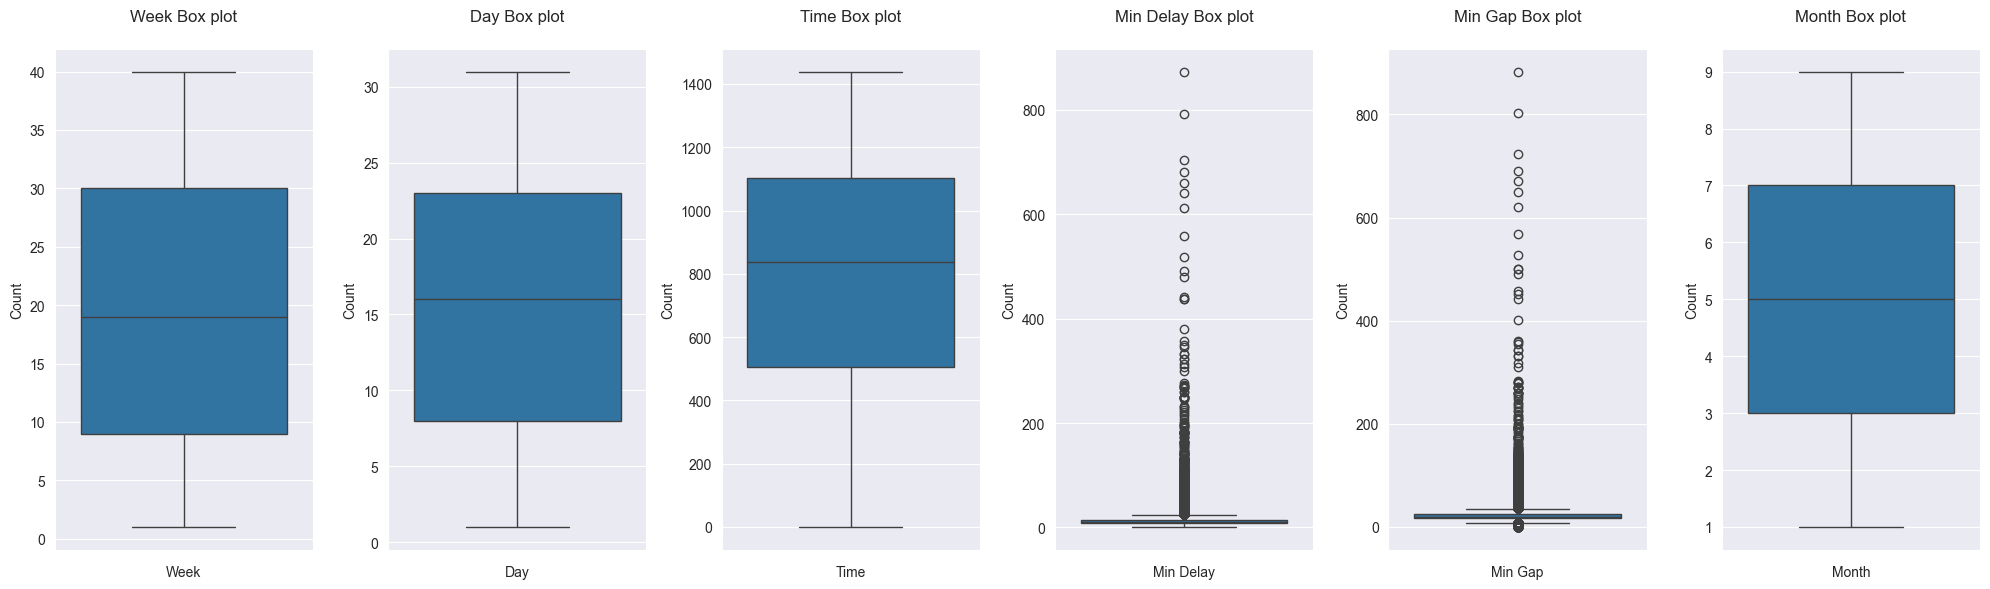

In [47]:
graficar_num = ['Week', 'Day', 'Time', 'Min Delay', 'Min Gap', 'Month']
plt.figure(figsize=(20, 6))

for idx, feature in enumerate(graficar_num, 1):
    plt.subplot(1, 6, idx)
    sns.boxplot(data=df, y=feature)
    plt.title(f'{feature} Box plot', pad=20)
    plt.xlabel(feature)
    plt.ylabel('Count')

plt.tight_layout()
plt.show()

 as we look at the graphs above there is some work to do, the Min Delay and Min Gap Box plot show a lot of outliers

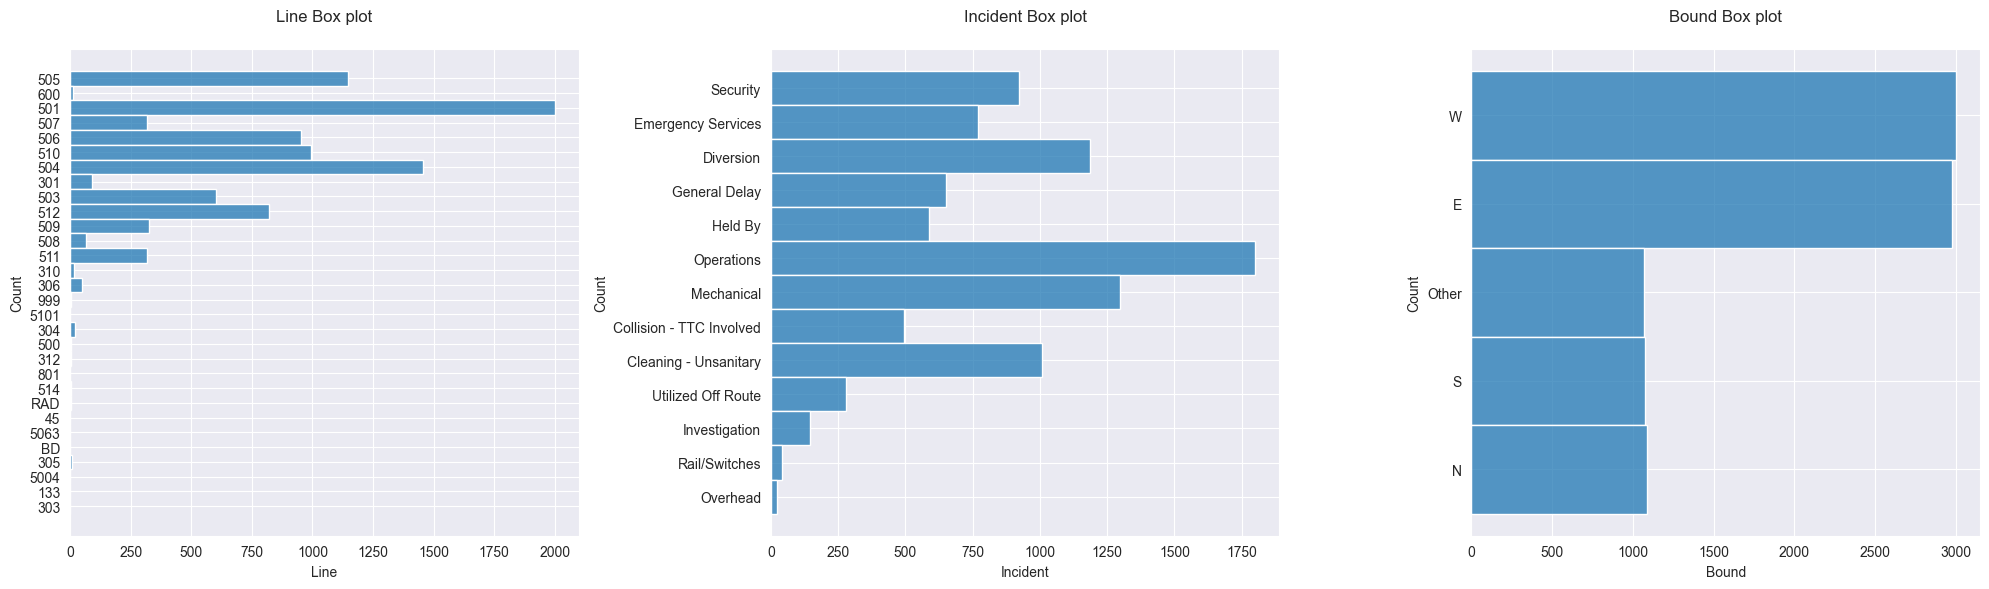

In [48]:
# Now let's analyze Categorical Features

cat = ['Line', 'Incident','Bound']
plt.figure(figsize=(20, 6))

for idx, feature in enumerate(cat, 1):
    plt.subplot(1, 3, idx)
    sns.histplot(data=df, y=feature)
    plt.title(f'{feature} Box plot', pad=20)
    plt.xlabel(feature)
    plt.ylabel('Count')

plt.tight_layout()
plt.show()


When we select those columns with less than 100 "unique" values we can see that the is an interesting concentration of values on specific lines, an even in the incident causes, also the direction has values that "concentrate" in certain areas

In [49]:
df[("Vehicle")].value_counts()

Vehicle
0       151
4566     52
4571     49
4588     48
4494     48
       ... 
3353      1
7049      1
3128      1
7086      1
1351      1
Name: count, Length: 1012, dtype: int64

In [50]:
df[("Location")].value_counts()

Location
SPADINA STATION           221
BROADVIEW STATION         219
DUNDAS WEST STATION       196
WOLSELEY LOOP             134
HUMBER LOOP               107
                         ... 
KINGSTON RD AND BROOKS      1
COLLEGE AND BEVERELY        1
RONCESALLES YARD            1
WOLESELY LOOP               1
KINGSTON ROAD AND WEVE      1
Name: count, Length: 1630, dtype: int64

In [51]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
# now this categorical features lets "turn" them into numerical values
df['Line'] = le.fit_transform(df['Line'])
df['Incident'] = le.fit_transform(df['Incident'])
df['Bound'] = le.fit_transform(df['Bound'])
# we are using One hot encoder as thery don't have an order and as the frequency doesnt matter
df_encoded = pd.get_dummies(df, columns=["Location", "Location"],
                           prefix=['Location', 'Vehicle'])
df.drop("Location", axis=1, inplace=True)
df.drop("Vehicle", axis=1, inplace=True)

The values of location and Vehicle are specific, that why we have a lot of unique values, it is important to notice that there are some missing values in vehicle represented by "0", one solution could be getting random values and using them but for the moment we are leaving them as they are.

In [52]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_squared_error, r2_score
import xgboost as xgb
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc


X = df.drop('Min Delay', axis=1)
y = df['Min Delay']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=101, train_size=0.7)
X.head()

,Week,Line,Time,Day,Incident,Min Gap,Bound,Month
0,1,14,165,1,11,20,4,1
1,1,14,186,1,3,72,0,1
3,1,14,233,1,11,0,4,1
4,1,25,267,1,2,93,0,1
5,1,11,273,1,2,84,0,1


In [53]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train) #Fit transform en entrenamiento
X_test_scaled = scaler.transform(X_test) #Transform solo en prueba

In [54]:
model = LinearRegression()
model.fit(X_train_scaled, y_train)
y_pred = model.predict(X_test_scaled)

In [55]:
print(f"""
Coeficientes: {model.coef_}
Intercepto: {model.intercept_}
RMSE: {np.sqrt(mean_squared_error(y_test,y_pred))}
R2: {r2_score(y_test,y_pred)}
""")


Coeficientes: [ 7.39185268  0.88956096  0.4305411  -0.85386997 -0.10296626 34.99213002
 -0.127955   -7.11495863]
Intercepto: 18.687606638746704
RMSE: 9.963897174142412
R2: 0.8996599484789259



In [56]:
#Calcular residuos
residuals = y_test-model.predict(X_test_scaled)
residuals = residuals.values
residuals

array([-1.21246823, -0.01108042, -1.68269925, ..., -1.84436472,
       -1.16850549,  0.56924694])

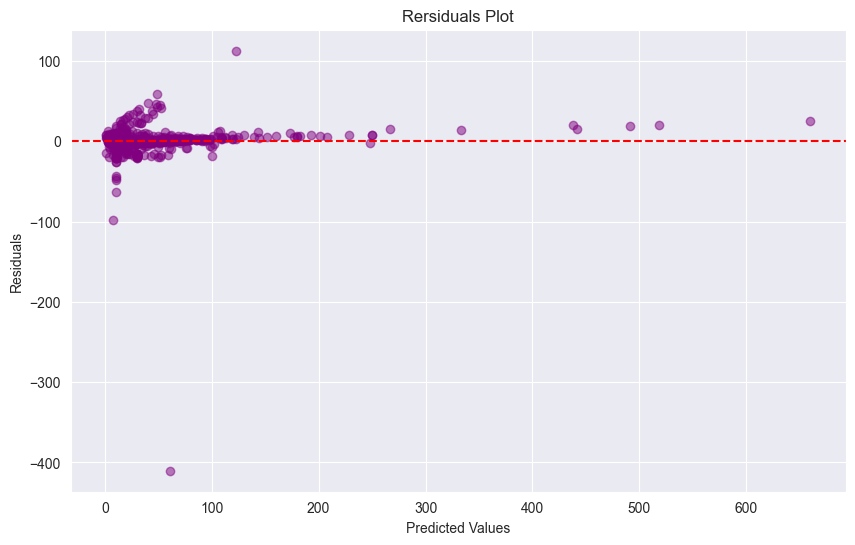

In [57]:
plt.figure(figsize=(10,6))
plt.scatter(y_test, residuals, color='purple', alpha=0.5)
plt.axhline(y=0, color='red',linestyle='--')
plt.title('Rersiduals Plot')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.show()

<Axes: xlabel='residuals', ylabel='Density'>

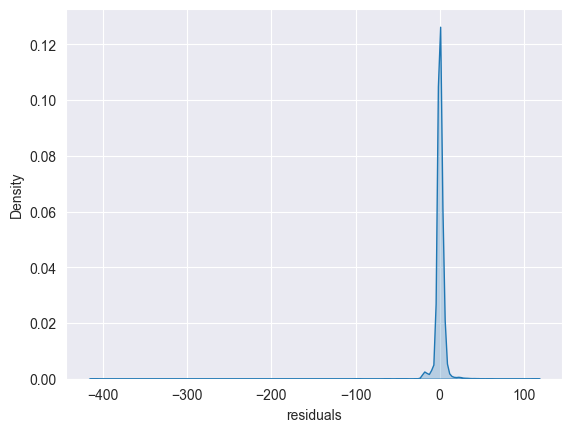

In [58]:
residuals = residuals.reshape(1,-1)
residuals = residuals[0]
res_df = pd.DataFrame({'residuals':residuals})
sns.kdeplot(res_df, x='residuals',fill=True)

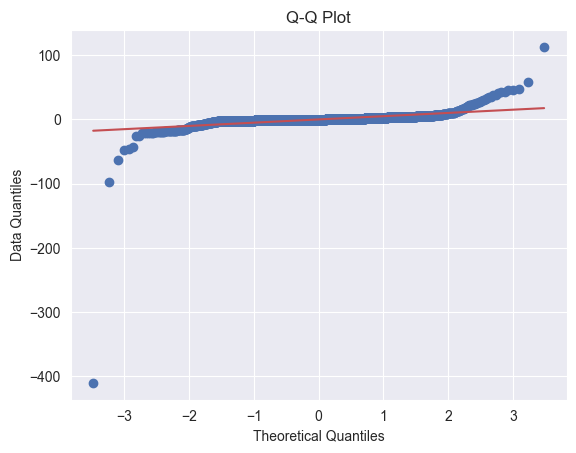

In [59]:
(osm,osr),(slope,intercept,r) = stats.probplot(residuals, dist='norm', plot=plt)
sns.set(style='whitegrid')
plt.title('Q-Q Plot')
plt.xlabel('Theoretical Quantiles')
plt.ylabel('Data Quantiles')
plt.show()

In [60]:
statistic, p_value = stats.shapiro(residuals)

print(f"Estadistico:{statistic}")
print(f"Valor P:{p_value}")

alpha = 0.05

if p_value <alpha:
  print("Rechazamos la hipotesis nula: los datos no siguen una distribucion normal")
else:
  print("Fallamos en rechazar la hipotesis nula. Los datos podrian seguir una distribucion normal")

Estadistico:0.261563241481781
Valor P:0.0
Rechazamos la hipotesis nula: los datos no siguen una distribucion normal
